Importing the desired modules

In [1]:
import numpy as np
from vtk import vtkStructuredPointsReader
from vtkmodules.util import numpy_support as VN
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
import pandas as pd

Reading the vtk file 

In [18]:
reader = vtkStructuredPointsReader()
reader.SetFileName("100G_lndem_3D.vtk")
reader.ReadAllVectorsOn()
reader.ReadAllScalarsOn()
reader.Update()

data = reader.GetOutput()
dim = data.GetDimensions()
#print(data)
Ox,Oy,Oz=data.GetOrigin()
Sx,Sy,Sz=data.GetSpacing()

u = VN.vtk_to_numpy(data.GetPointData().GetArray('lndem_3d'))
b = VN.vtk_to_numpy(data.GetPointData().GetArray('log10T'))

u = u.reshape(dim,order='F')
b = b.reshape(dim,order='F')

x = np.zeros(data.GetNumberOfPoints())
y = np.zeros(data.GetNumberOfPoints())
z = np.zeros(data.GetNumberOfPoints())

for i in range(data.GetNumberOfPoints()):
        x[i],y[i],z[i] = data.GetPoint(i)

x = x.reshape(dim,order='F')
y = y.reshape(dim,order='F')
z = z.reshape(dim,order='F')


In [3]:
print(dim[2])
print(Oz + Sz*(dim[2]-1))

62
20.33871594


Extracting the required subset

In [4]:
x_sub=x[0:301, 110:730, 0:61]
y_sub=y[0:301, 110:730, 0:61]
z_sub=z[0:301, 110:730, 0:61]

print(np.shape(x))
print(np.shape(y))
print(np.shape(z))

(774, 730, 62)
(774, 730, 62)
(774, 730, 62)


Making the 2D slash cut at a specified height 

In [5]:
x_slash=x[0:301, 150:151, 0:61]
y_slash=y[0:301, 150:151, 0:61]
z_slash=z[0:301, 150:151, 0:61]
b_slash=b[0:301, 150:151, 0:61]
u_slash=u[499:501, 200:202, 4:6]

#print(x_slash)
print(u[499,151,30])
#print(u_slash[250][0][55],x_slash[55][0][55],z_slash[55][0][55])

0.2338428


Plotting the contours manually using the contour function of matplotlib and using the default color scheme offered by the function

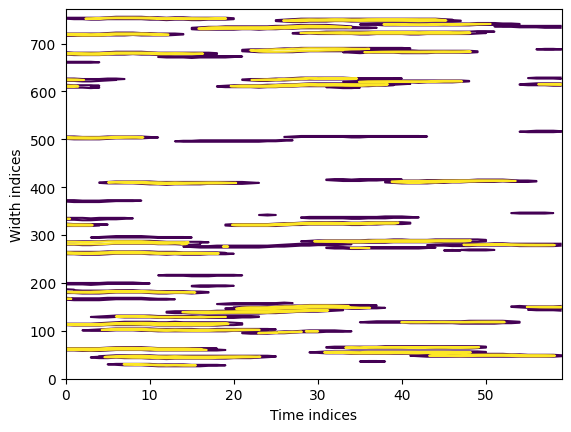

In [19]:
#grange function replaced with arange in python while bytscl is replaced 
#with np.clip and astype, np.floor is used for refoming and levels is used to clor scheming

# Assuming lndem_3D is a numpy array containing the data
lndem_3D=u
nx, nz, nt = lndem_3D.shape

# Reform and bytscl the data  
data = np.clip(np.floor(255 * (lndem_3D[0:nx-1, 400, 0:nt-1] + 3) / 3), 0, 255).astype(np.uint8)

# Set up x and time arrays
x = np.arange(nx-1)
time = np.arange(nt-1)
[X,Y]=np.meshgrid(time,x)


# Set up contour levels
levels = np.arange(0, 255, 200)

# Plot the contour
cont = plt.contour(X,Y, data, levels=levels)

# Show the plot
plt.xlabel("Time indices")
plt.ylabel("Width indices")
plt.show()


Full code to read the vtk file but using the imshow function to plot the thermal plots rather than contour plots

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

def patch_count(slice_data, colors, id):
    # Define the threshold value for brightness
    threshold = 0.0 # This condition specifies the values at which to compute the isosurfaces

    # Apply the threshold to create a binary mask for bright spots
    binary_mask = np.where(slice_data > threshold, 1, 0)

    # Label the connected components (patches)
    labeled_mask, num_labels = ndimage.label(binary_mask)

    # Exclude the background label (0)
    num_patches = num_labels - 1

    if num_patches >0:
        return num_patches
    else:
        return 0

In [20]:
import vtk
from vtkmodules.util.numpy_support import vtk_to_numpy
from matplotlib.colors import ListedColormap

# Load the VTK file
reader = vtk.vtkStructuredPointsReader()
reader.SetFileName("100G_lndem_3D.vtk")
reader.Update()

# Get the data from the VTK file
data = reader.GetOutput()
dims = data.GetDimensions()
vtk_array = data.GetPointData().GetScalars()
np_array = vtk_to_numpy(vtk_array)
np_array = np_array.reshape(dims[2], dims[1], dims[0])
Origin=data.GetOrigin()
Spacing=data.GetSpacing()

# Define the color scheme
colors = plt.cm.hot_r

# Create an empty list or DataFrame to store the values
Spic_count = []; H_ind = []; H_Mm = []

# Perform the calculation in a for loop and append the results to the list or DataFrame
gap=3; start=180
N=(550-start)/gap # 165 for 100G, 180 for 200G, 183 for 300G
for i in range(0,round(N)):
    id=start + gap*i
    slice_data=np_array[:, id, :]
    spic=patch_count(slice_data, colors, id)
    H_max= Oy + Sy*(id-gap)
    
    Spic_count.append(spic)
    H_ind.append(id)
    H_Mm.append(Oy + id*Sy)
    if spic == 0 or H_max >= 28:
        break

# Create a dictionary with column names and their values
data_to_excel = {'Spicules': Spic_count,
        'Height[i]': H_ind,
        'Height (Mm)': H_Mm}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data_to_excel)

# Specify the file path and name for your Excel sheet
file_path = "100G_lndem_3D data.xlsx"

# Write the DataFrame to the Excel file using pandas
df.to_excel(file_path, index=False)

#Printing the height at whih the last spicules was counted      300G: 19.98, 200G: 21.81, 100G: 28.104
print(round(H_max,5))

28.10403


Without specifying the color scheme


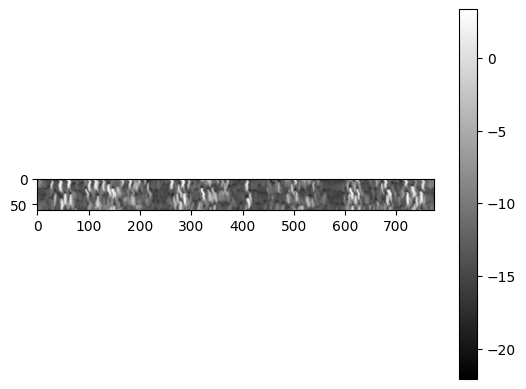

After specifying the color scheme


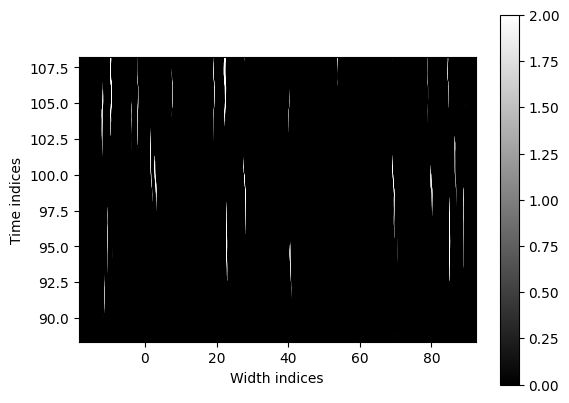

(-18.49966146, -5.17911441, 88.33334351)


In [22]:
slice_data=np_array[:, 400, :]

# Plot the slice data with the color scheme
print("Without specifying the color scheme")
plt.imshow(slice_data, cmap=colors)
plt.colorbar()
plt.show()

# Define the custom grayscale color scheme
colors_list = [(i/255.0, i/255.0, i/255.0) for i in range(256)]
values_list = [i for i in range(256)]
colors = ListedColormap(colors_list)

# Define the custom color scheme
'''colors_list = [(0.0, 0.0, 0.0), (1.0, 0.0, 0.0), (1.0, 1.0, 0.0),(1.0, 1.0, 1.0)]
values_list = [0, 10, 20, 30]
colors = ListedColormap(colors_list)'''

# Plot the slice data with the customized color scheme
print("After specifying the color scheme")
plt.imshow(slice_data, cmap=colors, vmin=0, vmax=2, extent=[Origin[0], Origin[0] + Spacing[0]*(dims[0]-1), Origin[2], Origin[2] + Spacing[2]*(dims[2]-1)],aspect=4) #extent is for resizing the axes and aspect is the ratio
plt.colorbar()
plt.xlabel("Width indices")
plt.ylabel("Time indices")
plt.show()

print(Origin)